### Models of Sentiment analysis 

In [1]:
import pandas as pd
import numpy as np
import re 
import nltk 
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold


from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib.patches as mpatches

In [2]:
Train = pd.read_csv('Corona_NLP_train.csv',encoding ='latin1',error_bad_lines=False)
Test = pd.read_csv('Corona_NLP_test.csv',encoding ='latin1',error_bad_lines=False)

In [3]:
Train['text'] = Train.OriginalTweet
Train["text"] = Train["text"].astype(str)

Test['text'] = Test.OriginalTweet
Test["text"] = Test["text"].astype(str)

# Data has 5 classes, let's convert them to 3

def classes_def(x):
    if x ==  "Extremely Positive":
        return "2"
    elif x == "Extremely Negative":
        return "0"
    elif x == "Negative":
        return "0"
    elif x ==  "Positive":
        return "2"
    else:
        return "1"
    

Train['label']=Train['Sentiment'].apply(lambda x:classes_def(x))
Test['label']=Test['Sentiment'].apply(lambda x:classes_def(x))


Train.label.value_counts(normalize= True)

2    0.438467
0    0.374128
1    0.187404
Name: label, dtype: float64

###  Text cleaning 

In [4]:
#Remove Urls and HTML links
def remove_urls(text):
    url_remove = re.compile(r'https?://\S+|www\.\S+')
    return url_remove.sub(r'', text)
Train['text_new']=Train['text'].apply(lambda x:remove_urls(x))
Test['text_new']=Test['text'].apply(lambda x:remove_urls(x))

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)
Train['text']=Train['text_new'].apply(lambda x:remove_html(x))
Test['text']=Test['text_new'].apply(lambda x:remove_html(x))

# Lower casing
def lower(text):
    low_text= text.lower()
    return low_text
Train['text_new']=Train['text'].apply(lambda x:lower(x))
Test['text_new']=Test['text'].apply(lambda x:lower(x))


# Number removal
def remove_num(text):
    remove= re.sub(r'\d+', '', text)
    return remove
Train['text']=Train['text_new'].apply(lambda x:remove_num(x))
Test['text']=Test['text_new'].apply(lambda x:remove_num(x))

#Remove stopwords & Punctuations
from nltk.corpus import stopwords
", ".join(stopwords.words('english'))
STOPWORDS = set(stopwords.words('english'))

def punct_remove(text):
    punct = re.sub(r"[^\w\s\d]","", text)
    return punct
Train['text_new']=Train['text'].apply(lambda x:punct_remove(x))
Test['text_new']=Test['text'].apply(lambda x:punct_remove(x))


def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
Train['text']=Train['text_new'].apply(lambda x:remove_stopwords(x))
Test['text']=Test['text_new'].apply(lambda x:remove_stopwords(x))

#Remove mentions and hashtags
def remove_mention(x):
    text=re.sub(r'@\w+','',x)
    return text
Train['text_new']=Train['text'].apply(lambda x:remove_mention(x))
Test['text_new']=Test['text'].apply(lambda x:remove_mention(x))

def remove_hash(x):
    text=re.sub(r'#\w+','',x)
    return text
Train['text']=Train['text_new'].apply(lambda x:remove_hash(x))
Test['text']=Test['text_new'].apply(lambda x:remove_hash(x))

#Remove extra white space left while removing stuff
def remove_space(text):
    space_remove = re.sub(r"\s+"," ",text).strip()
    return space_remove
Train['text_new']=Train['text'].apply(lambda x:remove_space(x))
Test['text_new']=Test['text'].apply(lambda x:remove_space(x))
Test = Test.drop(columns=['text_new'])
Train = Train.drop(columns=['text_new'])

In [5]:
stop_words = ['a', 'an', 'the']

# Basic cleansing
def cleansing(text):
    # Tokenize
    tokens = text.split(' ')
    # Lower case
    tokens = [w.lower() for w in tokens]
    # Remove stop words
    tokens = [w for w in tokens if w not in stop_words]
    return ' '.join(tokens)


# All-in-one preproce
def preprocess_x(x):
    processed_x = [cleansing(text) for text in x]
    
    return processed_x

Train['text_new']=Train['text'].apply(lambda x:preprocess_x(x))
Test['text_new']=Test['text'].apply(lambda x:preprocess_x(x))

#  Tf-IDF

from sklearn.model_selection import train_test_split

train,valid = train_test_split(train,test_size = 0.2,random_state=0,stratify = train.label.values) #stratification means that the train_test_split method returns training and test subsets that have the same proportions of class labels as the input dataset.
print("train shape : ", train.shape)
print("valid shape : ", valid.shape)

In [6]:
train = Train[['text','label']]
test = Test[['text','label']]

In [7]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                    
                        stop_words='english')

# We transform each text into a vector
X_train = tfidf.fit_transform(train.text)
X_test = tfidf.transform(test.text)

y_train = train.label
y_test = test.label

print("X_train.shape : ", X_train.shape)
print("X_valid.shape : ", X_test.shape)
print("y_train.shape : ", y_train.shape)
print("y_valid.shape : ", y_test.shape)

X_train.shape :  (41157, 10615)
X_valid.shape :  (3798, 10615)
y_train.shape :  (41157,)
y_valid.shape :  (3798,)


## Naives Bayes Classifier

In [8]:
from sklearn.metrics import mean_squared_error,mean_absolute_error, make_scorer,classification_report,confusion_matrix,accuracy_score,roc_auc_score,roc_curve
from sklearn.naive_bayes import MultinomialNB

naiveByes_clf = MultinomialNB()

naiveByes_clf.fit(X_train,y_train)

NB_prediction = naiveByes_clf.predict(X_test)
NB_accuracy = accuracy_score(y_test,NB_prediction)
print("training accuracy Score    : ",naiveByes_clf.score(X_train,y_train))
print("Validation accuracy Score : ",NB_accuracy )
print(classification_report(NB_prediction,y_test))

training accuracy Score    :  0.7362538571810384
Validation accuracy Score :  0.6708794102159031
              precision    recall  f1-score   support

           0       0.72      0.73      0.73      1599
           1       0.12      0.70      0.20       104
           2       0.84      0.62      0.72      2095

   micro avg       0.67      0.67      0.67      3798
   macro avg       0.56      0.69      0.55      3798
weighted avg       0.77      0.67      0.71      3798



In [9]:
from sklearn import metrics

In [10]:
metrics.accuracy_score(y_test,NB_prediction)

0.6708794102159031

In [11]:
metrics.f1_score(y_test,NB_prediction,average ='weighted')

0.6361293316230519

In [12]:
y = np.array([1, 1, 2, 2])
scores = np.array([0.1, 0.4, 0.35, 0.8])
fpr, tpr, thresholds = roc_curve(y, scores, pos_label=2)
fpr

array([0. , 0. , 0.5, 0.5, 1. ])

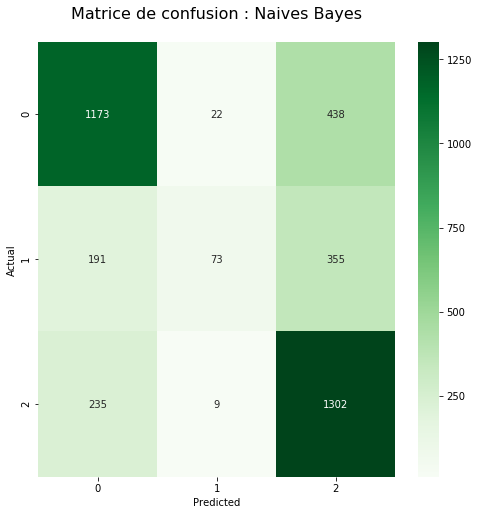

In [13]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics


conf_mat = confusion_matrix(y_test,NB_prediction)
fig, ax = plt.subplots(figsize=(8,8))

sns.heatmap(conf_mat, annot=True, cmap="Greens", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("Matrice de confusion : Naives Bayes\n", size=16);

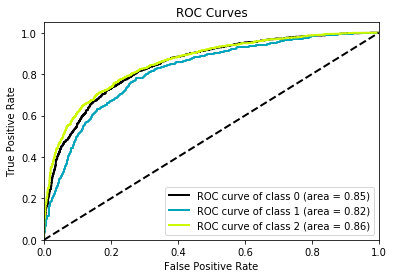

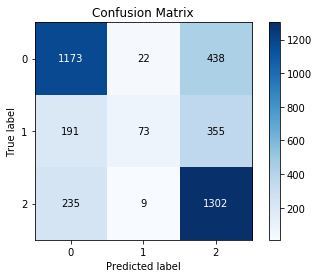

In [14]:
import scikitplot as skplt
y_probas = naiveByes_clf.predict_proba(X_test)

skplt.metrics.plot_roc(y_test, y_probas,plot_micro =False, plot_macro = False)
skplt.metrics.plot_confusion_matrix(y_test, NB_prediction)
plt.show()

## Stochastic Gradient Descent-SGD Classifier

In [15]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss = 'hinge', penalty = 'l2', random_state=0)

sgd_clf.fit(X_train,y_train)

sgd_prediction = sgd_clf.predict(X_test)
sgd_accuracy = accuracy_score(y_test,sgd_prediction)
print("Training accuracy Score    : ",sgd_clf.score(X_train,y_train))
print("Validation accuracy Score : ",sgd_accuracy )
print(classification_report(sgd_prediction,y_test))

C:\Users\berni\Nouveau dossier (4)\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


Training accuracy Score    :  0.8416308282916636
Validation accuracy Score :  0.7614533965244866
              precision    recall  f1-score   support

           0       0.79      0.77      0.78      1674
           1       0.45      0.75      0.56       367
           2       0.85      0.75      0.80      1757

   micro avg       0.76      0.76      0.76      3798
   macro avg       0.70      0.76      0.71      3798
weighted avg       0.79      0.76      0.77      3798



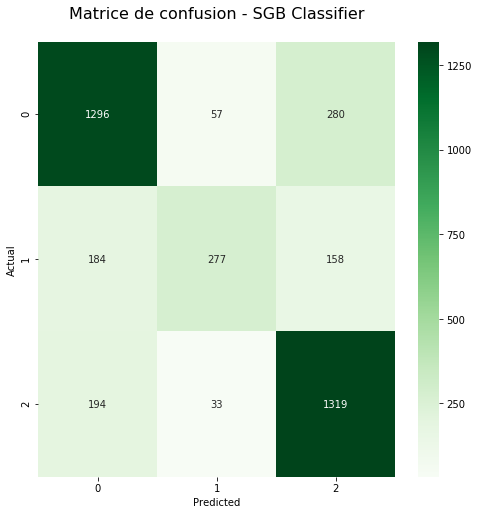

In [79]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics


conf_mat = confusion_matrix(y_test,sgd_prediction)
fig, ax = plt.subplots(figsize=(8,8))

sns.heatmap(conf_mat, annot=True, cmap="Greens", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("Matrice de confusion - SGD Classifier\n", size=16);

C:\Users\berni\Nouveau dossier (4)\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


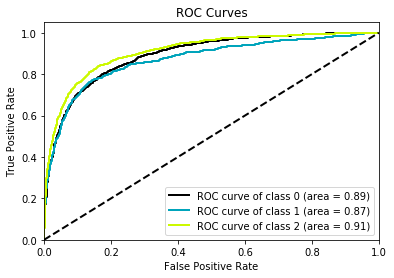

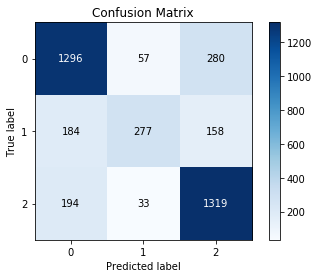

In [80]:
from sklearn.calibration import CalibratedClassifierCV
lr = SGDClassifier(loss='hinge',class_weight='balanced')
clf =lr.fit(X_train, y_train)
calibrator = CalibratedClassifierCV(clf, cv='prefit')
model=calibrator.fit(X_train, y_train)
y_probas = model.predict_proba(X_test)

import scikitplot as skplt
skplt.metrics.plot_roc(y_test, y_probas,plot_micro =False, plot_macro = False)
skplt.metrics.plot_confusion_matrix(y_test, sgd_prediction)
plt.show()

In [83]:
metrics.f1_score(y_test,sgd_prediction,average ='weighted')

0.7536777081733861

In [84]:
metrics.accuracy_score(y_test,sgd_prediction)

0.7614533965244866

# CountVectorizer

In [16]:
train

,text,label
0,menyrbie phil_gahan chrisitv,1
1,advice talk neighbours family exchange phone n...,2
2,coronavirus australia woolworths give elderly ...,2
3,food stock one empty please dont panic enough ...,2
4,ready go supermarket covid outbreak im paranoi...,0
...,...,...
41152,airline pilots offering stock supermarket shel...,1
41153,response complaint provided citing covid relat...,0
41154,know itâs getting tough kameronwilds rationing...,2
41155,wrong smell hand sanitizer starting turn coron...,1


In [17]:
# instantiate the vectorizer
vect = CountVectorizer(stop_words='english', ngram_range=(1,2))


In [18]:

# We transform each text into a vector
X_freq_train = vect.fit_transform(train.text.values)
X_freq_test = vect.transform(test.text.values)

y_freq_train = train.label
y_freq_test = test.label

print("X_train.shape : ", X_freq_train.shape)
print("X_test.shape : ", X_freq_test.shape)
print("y_train.shape : ", y_freq_train.shape)
print("y_test.shape : ", y_freq_test.shape)

X_train.shape :  (41157, 465096)
X_test.shape :  (3798, 465096)
y_train.shape :  (41157,)
y_test.shape :  (3798,)


## Naives Bayes Classifier

In [19]:
from sklearn.metrics import mean_squared_error,mean_absolute_error, make_scorer,classification_report,confusion_matrix,accuracy_score,roc_auc_score,roc_curve
from sklearn.naive_bayes import MultinomialNB

naiveByes_clf = MultinomialNB()

naiveByes_clf.fit(X_freq_train,y_freq_train)

NB_prediction = naiveByes_clf.predict(X_freq_test)
NB_accuracy = accuracy_score(y_freq_test,NB_prediction)
print("training accuracy Score    : ",naiveByes_clf.score(X_freq_train,y_freq_train))
print("Validation accuracy Score : ",NB_accuracy )
print(classification_report(NB_prediction,y_freq_test))

training accuracy Score    :  0.9468863133853294
Validation accuracy Score :  0.6445497630331753
              precision    recall  f1-score   support

           0       0.71      0.70      0.71      1646
           1       0.04      0.86      0.07        28
           2       0.82      0.60      0.69      2124

   micro avg       0.64      0.64      0.64      3798
   macro avg       0.52      0.72      0.49      3798
weighted avg       0.77      0.64      0.69      3798



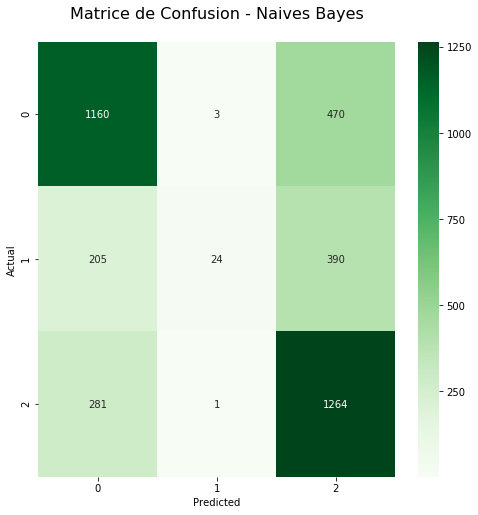

In [20]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics


conf_mat = confusion_matrix(y_freq_test,NB_prediction)
fig, ax = plt.subplots(figsize=(8,8))

sns.heatmap(conf_mat, annot=True, cmap="Greens", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("Matrice de Confusion - Naives Bayes\n", size=16);

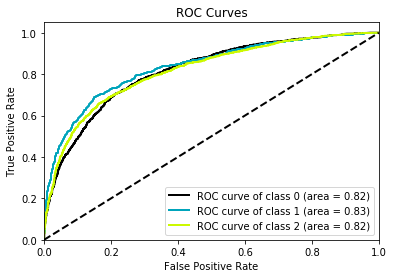

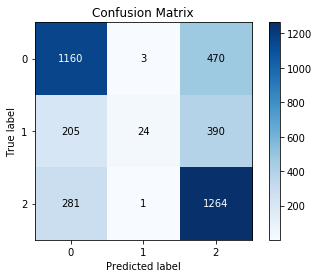

In [21]:
import scikitplot as skplt
y_probas = naiveByes_clf.predict_proba(X_freq_test)

skplt.metrics.plot_roc(y_freq_test, y_probas,plot_micro = False, plot_macro= False)
skplt.metrics.plot_confusion_matrix(y_freq_test, NB_prediction)
plt.show()

In [22]:
metrics.accuracy_score(y_freq_test,NB_prediction)

0.6445497630331753

In [23]:
metrics.f1_score(y_freq_test,NB_prediction,average ='weighted')

0.5966962526337581

## Stochastic Gradient Descent-SGD Classifier

In [24]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss = 'hinge', penalty = 'l2', random_state=0)

sgd_clf.fit(X_freq_train,y_freq_train)

sgd_prediction = sgd_clf.predict(X_freq_test)
sgd_accuracy = accuracy_score(y_freq_test,sgd_prediction)
print("Training accuracy Score    : ",sgd_clf.score(X_freq_train,y_freq_train))
print("Validation accuracy Score : ",sgd_accuracy )
print(classification_report(sgd_prediction,y_freq_test))

C:\Users\berni\Nouveau dossier (4)\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


Training accuracy Score    :  0.9959180698301625
Validation accuracy Score :  0.7643496577145866
              precision    recall  f1-score   support

           0       0.76      0.80      0.78      1557
           1       0.59      0.69      0.63       529
           2       0.84      0.76      0.80      1712

   micro avg       0.76      0.76      0.76      3798
   macro avg       0.73      0.75      0.74      3798
weighted avg       0.77      0.76      0.77      3798



In [25]:
metrics.accuracy_score(y_freq_test,sgd_prediction)

0.7643496577145866

In [26]:
metrics.f1_score(y_freq_test,sgd_prediction,average ='weighted')

0.7622597831850707

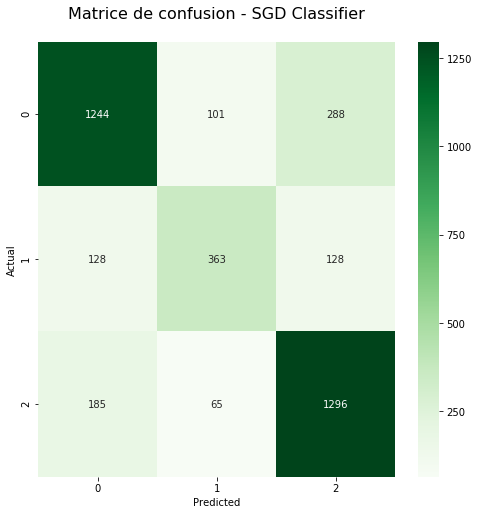

In [28]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics


conf_mat = confusion_matrix(y_freq_test,sgd_prediction)
fig, ax = plt.subplots(figsize=(8,8))

sns.heatmap(conf_mat, annot=True, cmap="Greens", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("Matrice de confusion - SGD Classifier\n", size=16);

C:\Users\berni\Nouveau dossier (4)\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


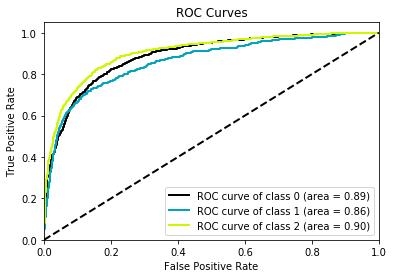

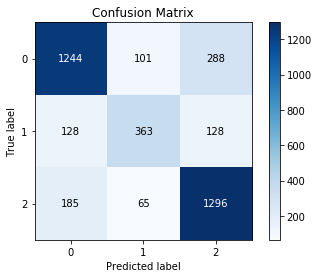

In [79]:
from sklearn.calibration import CalibratedClassifierCV
lr = SGDClassifier(loss='hinge',class_weight='balanced')
clf =lr.fit(X_freq_train,y_freq_train)
calibrator = CalibratedClassifierCV(clf, cv='prefit')
model=calibrator.fit(X_freq_train,y_freq_train)
y_probas = model.predict_proba(X_freq_test)

import scikitplot as skplt
skplt.metrics.plot_roc(y_freq_test, y_probas,plot_micro =False, plot_macro = False)
skplt.metrics.plot_confusion_matrix(y_freq_test, sgd_prediction)
plt.show()

In [23]:
from sklearn import metrics
metrics.confusion_matrix(sgd_prediction, y_freq_test)

array([[1244,  128,  185],
       [ 101,  363,   65],
       [ 288,  128, 1296]], dtype=int64)

# Données Lemmatisées

In [32]:
Train

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,text,label,text_new
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,menyrbie phil_gahan chrisitv,1,"[m, e, n, y, r, b, i, e, , p, h, i, l, _, g, ..."
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,advice talk neighbours family exchange phone n...,2,"[, d, v, i, c, e, , t, , l, k, , n, e, i, g,..."
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,coronavirus australia woolworths give elderly ...,2,"[c, o, r, o, n, , v, i, r, u, s, , , u, s, t,..."
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive,food stock one empty please dont panic enough ...,2,"[f, o, o, d, , s, t, o, c, k, , o, n, e, , ..."
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,ready go supermarket covid outbreak im paranoi...,0,"[r, e, , d, y, , g, o, , s, u, p, e, r, m, ,..."
...,...,...,...,...,...,...,...,...,...
41152,44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,Neutral,airline pilots offering stock supermarket shel...,1,"[, i, r, l, i, n, e, , p, i, l, o, t, s, , o..."
41153,44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVI...,Extremely Negative,response complaint provided citing covid relat...,0,"[r, e, s, p, o, n, s, e, , c, o, m, p, l, , i..."
41154,44953,89905,NaN,14-04-2020,You know itÂs getting tough when @KameronWild...,Positive,know itâs getting tough kameronwilds rationing...,2,"[k, n, o, w, , i, t, â, s, , g, e, t, t, i, ..."
41155,44954,89906,NaN,14-04-2020,Is it wrong that the smell of hand sanitizer i...,Neutral,wrong smell hand sanitizer starting turn coron...,1,"[w, r, o, n, g, , s, m, e, l, l, , h, , n, d..."


In [33]:
def get_lemmatized_text(corpus):
    from nltk.stem import WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    return [' '.join([lemmatizer.lemmatize(word) for word in review.split()]) for review in corpus]

Train['text2'] = get_lemmatized_text(Train.text)
Test['text2'] = get_lemmatized_text(Test.text)

In [34]:
Train

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,text,label,text_new,text2
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,menyrbie phil_gahan chrisitv,1,"[m, e, n, y, r, b, i, e, , p, h, i, l, _, g, ...",menyrbie phil_gahan chrisitv
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,advice talk neighbours family exchange phone n...,2,"[, d, v, i, c, e, , t, , l, k, , n, e, i, g,...",advice talk neighbour family exchange phone nu...
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,coronavirus australia woolworths give elderly ...,2,"[c, o, r, o, n, , v, i, r, u, s, , , u, s, t,...",coronavirus australia woolworth give elderly d...
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive,food stock one empty please dont panic enough ...,2,"[f, o, o, d, , s, t, o, c, k, , o, n, e, , ...",food stock one empty please dont panic enough ...
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,ready go supermarket covid outbreak im paranoi...,0,"[r, e, , d, y, , g, o, , s, u, p, e, r, m, ,...",ready go supermarket covid outbreak im paranoi...
...,...,...,...,...,...,...,...,...,...,...
41152,44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,Neutral,airline pilots offering stock supermarket shel...,1,"[, i, r, l, i, n, e, , p, i, l, o, t, s, , o...",airline pilot offering stock supermarket shelf...
41153,44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVI...,Extremely Negative,response complaint provided citing covid relat...,0,"[r, e, s, p, o, n, s, e, , c, o, m, p, l, , i...",response complaint provided citing covid relat...
41154,44953,89905,NaN,14-04-2020,You know itÂs getting tough when @KameronWild...,Positive,know itâs getting tough kameronwilds rationing...,2,"[k, n, o, w, , i, t, â, s, , g, e, t, t, i, ...",know itâs getting tough kameronwilds rationing...
41155,44954,89906,NaN,14-04-2020,Is it wrong that the smell of hand sanitizer i...,Neutral,wrong smell hand sanitizer starting turn coron...,1,"[w, r, o, n, g, , s, m, e, l, l, , h, , n, d...",wrong smell hand sanitizer starting turn coron...


In [35]:
train = Train[['text2','label']]
test = Test[['text2','label']]

In [36]:
# We transform each text into a vector
X_freq_train = vect.fit_transform(train.text2.values)
X_freq_test = vect.transform(test.text2.values)

y_freq_train = train.label
y_freq_test = test.label

print("X_train.shape : ", X_freq_train.shape)
print("X_test.shape : ", X_freq_test.shape)
print("y_train.shape : ", y_freq_train.shape)
print("y_test.shape : ", y_freq_test.shape)

X_train.shape :  (41157, 441983)
X_test.shape :  (3798, 441983)
y_train.shape :  (41157,)
y_test.shape :  (3798,)


In [37]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss = 'hinge', penalty = 'l2', random_state=0)

sgd_clf.fit(X_freq_train,y_freq_train)

sgd_prediction = sgd_clf.predict(X_freq_test)
sgd_accuracy = accuracy_score(y_freq_test,sgd_prediction)
print("Training accuracy Score    : ",sgd_clf.score(X_freq_train,y_freq_train))
print("Validation accuracy Score : ",sgd_accuracy )
print(classification_report(sgd_prediction,y_freq_test))

C:\Users\berni\Nouveau dossier (4)\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


Training accuracy Score    :  0.9946546152537843
Validation accuracy Score :  0.7530279094260137
              precision    recall  f1-score   support

           0       0.72      0.81      0.76      1448
           1       0.63      0.62      0.62       628
           2       0.84      0.75      0.79      1722

   micro avg       0.75      0.75      0.75      3798
   macro avg       0.73      0.73      0.73      3798
weighted avg       0.76      0.75      0.75      3798



## Prediction sur tableaux des urls, hastags et autre 

In [38]:
data = pd.read_csv('data_eda.csv', sep =',')
data_test = pd.read_csv('data_eda_test.csv', sep =',')

In [39]:
data.head(10)

,count_words,count_mentions,count_hashtags,count_capital_words,count_excl_quest_marks,count_urls,sentiment
0,17,3,0,0,0,3,Neutral
1,38,0,0,1,0,0,Positive
2,18,0,0,1,0,1,Positive
3,46,0,7,8,0,1,Positive
4,45,0,6,0,0,1,Extremely Negative
5,41,1,0,1,0,1,Positive
6,33,0,1,0,0,1,Positive
7,17,0,3,0,0,1,Neutral
8,50,0,0,1,2,1,Positive
9,44,0,2,1,1,0,Negative


In [40]:
data_test.shape

(3798, 7)

In [41]:
def classes_def(x):
    if x ==  "Extremely Positive":
        return "2"
    elif x == "Extremely Negative":
        return "0"
    elif x == "Negative":
        return "0"
    elif x ==  "Positive":
        return "2"
    else:
        return "1"
    

data['sentiment']=data['sentiment'].apply(lambda x:classes_def(x))
data_test['sentiment']= data_test['sentiment'].apply(lambda x:classes_def(x))


In [42]:
X_train = data.drop(columns = ['sentiment'])
X_test = data_test.drop(columns =['sentiment'])
y_train = data['sentiment']
y_test = data_test['sentiment']

In [43]:
naiveByes_clf = MultinomialNB()

naiveByes_clf.fit(X_train,y_train)

NB_prediction = naiveByes_clf.predict(X_test)
NB_accuracy = accuracy_score(y_test,NB_prediction)
print("training accuracy Score    : ",naiveByes_clf.score(X_train,y_train))
print("Validation accuracy Score : ",NB_accuracy )
print(classification_report(NB_prediction,y_test))

training accuracy Score    :  0.39796389435575963
Validation accuracy Score :  0.3962611901000527
              precision    recall  f1-score   support

           0       0.30      0.49      0.37       999
           1       0.30      0.26      0.28       715
           2       0.54      0.40      0.46      2084

   micro avg       0.40      0.40      0.40      3798
   macro avg       0.38      0.38      0.37      3798
weighted avg       0.43      0.40      0.40      3798



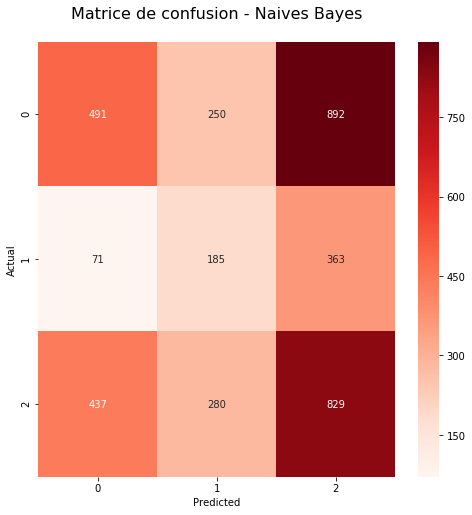

In [44]:
conf_mat = confusion_matrix(y_test, NB_prediction)
fig, ax = plt.subplots(figsize=(8,8))

sns.heatmap(conf_mat, annot=True, cmap="Reds", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("Matrice de confusion - Naives Bayes\n", size=16);

In [45]:
metrics.accuracy_score(y_test,NB_prediction)

0.3962611901000527

In [46]:
metrics.f1_score(y_test,NB_prediction,average ='weighted')

0.3915465740615997

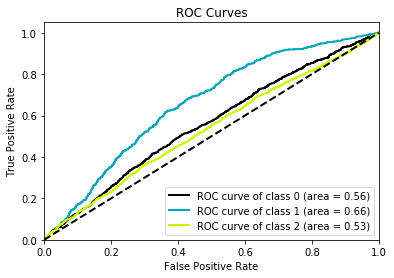

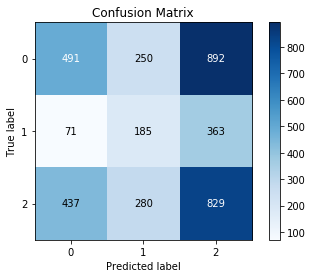

In [47]:
import scikitplot as skplt
y_probas = naiveByes_clf.predict_proba(X_test)

skplt.metrics.plot_roc(y_test, y_probas,plot_micro = False, plot_macro = False)
skplt.metrics.plot_confusion_matrix(y_test, NB_prediction)
plt.show()

In [48]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss = 'hinge', penalty = 'l2', random_state=0)

sgd_clf.fit(X_train,y_train)

sgd_prediction = sgd_clf.predict(X_test)
sgd_accuracy = accuracy_score(y_test,sgd_prediction)
print("Training accuracy Score    : ",sgd_clf.score(X_train,y_train))
print("Validation accuracy Score : ",sgd_accuracy )
print(classification_report(sgd_prediction,y_test))

Training accuracy Score    :  0.3784532400320723
Validation accuracy Score :  0.4347024749868352
              precision    recall  f1-score   support

           0       1.00      0.43      0.60      3761
           1       0.03      0.64      0.06        28
           2       0.00      0.67      0.01         9

   micro avg       0.43      0.43      0.43      3798
   macro avg       0.34      0.58      0.22      3798
weighted avg       0.99      0.43      0.60      3798



C:\Users\berni\Nouveau dossier (4)\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


In [49]:
metrics.f1_score(y_test,sgd_prediction,average ='weighted')

0.27159054173318287

In [50]:
metrics.accuracy_score(y_test,sgd_prediction)

0.4347024749868352

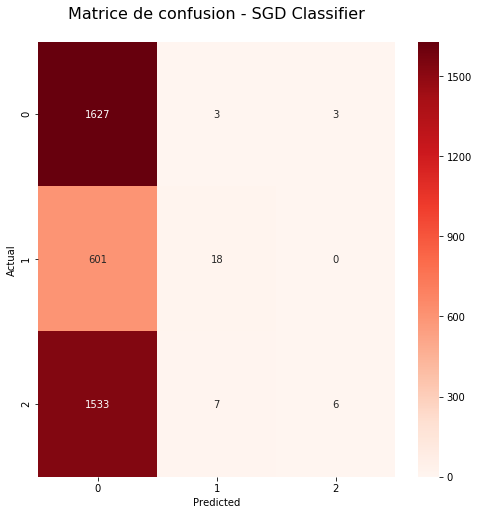

In [51]:
conf_mat = confusion_matrix(y_test, sgd_prediction)
fig, ax = plt.subplots(figsize=(8,8))

sns.heatmap(conf_mat, annot=True, cmap="Reds", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("Matrice de confusion - SGD Classifier\n", size=16);

C:\Users\berni\Nouveau dossier (4)\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\berni\Nouveau dossier (4)\lib\site-packages\sklearn\calibration.py:445: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
C:\Users\berni\Nouveau dossier (4)\lib\site-packages\sklearn\calibration.py:455: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
C:\Users\berni\Nouveau dossier (4)\lib\site-packages\sklearn\calibration.py:457: RuntimeWarning: invalid value encountered in multiply
  TEP_minus_T1P = P * (T * E - T1)
C:\Users\berni\Nouveau dossier (4)\lib\site-packages\sklearn\calibration.py:445: RuntimeWarning: overflow encountered i

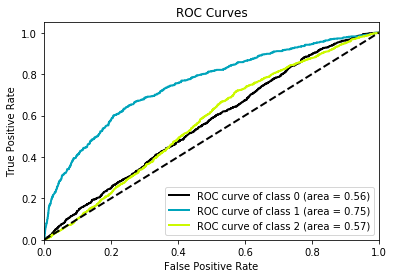

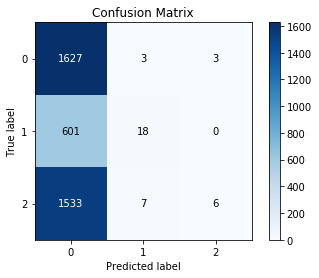

In [91]:
from sklearn.calibration import CalibratedClassifierCV
lr = SGDClassifier(loss='hinge',class_weight='balanced')
clf =lr.fit(X_train,y_train)
calibrator = CalibratedClassifierCV(clf, cv='prefit')
model=calibrator.fit(X_train,y_train)
y_probas = model.predict_proba(X_test)

import scikitplot as skplt
skplt.metrics.plot_roc(y_test, y_probas,plot_micro =False, plot_macro = False)
skplt.metrics.plot_confusion_matrix(y_test, sgd_prediction)
plt.show()

In [88]:
from sklearn.decomposition import LatentDirichletAllocation

In [37]:
vectorizer = CountVectorizer(
analyzer='word',       
min_df=3,# minimum required occurences of a word 
stop_words='english',# remove stop words
lowercase=True,# convert all words to lowercase
token_pattern='[a-zA-Z0-9]{3,}',# num chars > 3
max_features=5000,# max number of unique words
)            

In [38]:
autre_train = vectorizer.fit_transform(train.text2)

In [46]:
lda_model = LatentDirichletAllocation(
n_components=10, # Number of topics
learning_method='online',
random_state=20,       
n_jobs = -1  # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(autre_train)

In [48]:
#!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()


In [56]:
pyLDAvis.prepare(lda_model, autre_train, vectorizer)

TypeError: prepare() missing 2 required positional arguments: 'vocab' and 'term_frequency'

In [39]:
s = pd.Series(['dog',

                '',

                5,

                {'foo' : 'bar'},

                [2, 3, 5, 7],

                ('one', 'two', 'three')])



In [40]:
s

0                  dog
1                     
2                    5
3       {'foo': 'bar'}
4         [2, 3, 5, 7]
5    (one, two, three)
dtype: object

In [41]:
s.str.len()

0    3.0
1    0.0
2    NaN
3    1.0
4    4.0
5    3.0
dtype: float64

In [68]:
x.shape

(100,)

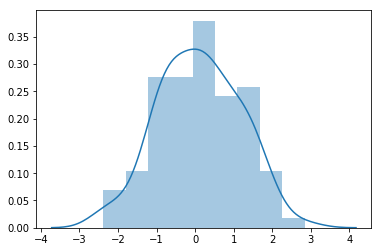

In [61]:
import seaborn as sns, numpy as np

x = np.random.randn(100)

ax = sns.distplot(x)

In [66]:
x

array([ 1.38166575e+00, -4.11715388e-02,  2.62734227e-01,  1.45496761e+00,
       -6.55311763e-01, -1.16682875e+00,  6.42174636e-01,  1.54347340e+00,
        5.65272877e-02,  7.65011603e-01,  1.13501190e+00, -5.75217973e-01,
       -2.35842750e+00,  5.27877235e-01, -1.45353754e-01, -7.72662107e-01,
       -5.35825506e-01,  1.35458989e+00, -6.13768791e-01, -2.78380375e-01,
        4.37607594e-01, -7.42968645e-01,  1.91227554e+00, -7.89422403e-01,
        7.44018414e-01, -6.31048086e-01, -3.68272513e-01,  1.53137577e+00,
       -2.04645632e+00,  1.46185486e-01, -1.28381721e+00, -2.38338084e+00,
        4.90612342e-01,  5.58793451e-02,  1.86857099e+00, -6.29258356e-01,
        1.45428111e+00, -5.60758204e-01,  5.93269234e-01, -2.79966022e-01,
        1.24605720e+00,  6.71492092e-01,  3.28127104e-02,  4.36395309e-01,
        6.03611394e-01, -8.84958959e-01, -9.91500392e-01, -1.35771796e-01,
       -2.10989364e-01,  2.12739923e+00,  7.79461955e-01, -4.37853494e-01,
        3.46995799e-01,  